<a href="https://colab.research.google.com/github/SkyyRon/TrafficDensity/blob/main/trafficdensity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install ultralytics


  Using cached ultralytics-8.3.129-py3-none-any.whl.metadata (37 kB)
  Using cached ultralytics_thop-2.0.14-py3-none-any.whl.metadata (9.4 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
Using cached ultralytics-8.3.129-py3-none-any.whl (1.0 MB)
Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl (363.4 MB)
Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl (664.8 MB)
Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl (127.9 MB)
Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl (207.5 MB)
Using cached ultralytics_thop-2.0.14-py3-none-any.whl (26 kB)
  

In [4]:
# Standard libraries
import os
import shutil
import math

# Numerical and data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image and video processing
import cv2
from PIL import Image

# YAML file handling
import yaml

# Model - YOLOv10 (from ultralytics)
from ultralytics import YOLO

# Jupyter display tools
from IPython.display import Video, display


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
pip install pyyaml


In [5]:
sns.set_theme(
    style='darkgrid',
    rc={
        'axes.facecolor': '#f5f5ff',      # Light lavender background
        'figure.facecolor': '#ffffff',   # White background for figures
        'axes.edgecolor': '#4a4a4a',     # Darker axis borders
        'grid.color': '#ccccff',         # Softer grid color
        'axes.labelcolor': '#333333',    # Axis label color
        'xtick.color': '#444444',
        'ytick.color': '#444444',
        'font.family': 'sans-serif',
        'font.sans-serif': 'DejaVu Sans',
    }
)



In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("farzadnekouei/top-view-vehicle-detection-image-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/top-view-vehicle-detection-image-dataset


In [7]:
dataset_path = '/kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset'

# Set the path to the YAML file
yaml_file_path = os.path.join(dataset_path, 'data.yaml')

# Load and print the contents of the YAML file
with open(yaml_file_path, 'r') as file:
    yaml_content = yaml.load(file, Loader=yaml.FullLoader)
    print(yaml.dump(yaml_content, default_flow_style=False))

names:
- Vehicle
nc: 1
roboflow:
  license: CC BY 4.0
  project: vehicle_detection_yolov8
  url: https://universe.roboflow.com/farzad/vehicle_detection_yolov8/dataset/3
  version: 3
  workspace: farzad
train: ../train/images
val: ../valid/images



In [8]:
# Set paths for training and validation image sets
train_images_path = os.path.join(dataset_path, 'train', 'images')
valid_images_path = os.path.join(dataset_path, 'valid', 'images')

# Initialize counters for the number of images
num_train_images = 0
num_valid_images = 0

# Initialize sets to hold the unique sizes of images
train_image_sizes = set()
valid_image_sizes = set()

# Check train images sizes and count
for filename in os.listdir(train_images_path):
    if filename.endswith('.jpg'):
        num_train_images += 1
        image_path = os.path.join(train_images_path, filename)
        with Image.open(image_path) as img:
            train_image_sizes.add(img.size)

# Check validation images sizes and count
for filename in os.listdir(valid_images_path):
    if filename.endswith('.jpg'):
        num_valid_images += 1
        image_path = os.path.join(valid_images_path, filename)
        with Image.open(image_path) as img:
            valid_image_sizes.add(img.size)

# Print the results
print(f"Number of training images: {num_train_images}")
print(f"Number of validation images: {num_valid_images}")

# Check if all images in training set have the same size
if len(train_image_sizes) == 1:
    print(f"All training images have the same size: {train_image_sizes.pop()}")
else:
    print("Training images have varying sizes.")

# Check if all images in validation set have the same size
if len(valid_image_sizes) == 1:
    print(f"All validation images have the same size: {valid_image_sizes.pop()}")
else:
    print("Validation images have varying sizes.")

Number of training images: 536
Number of validation images: 90
All training images have the same size: (640, 640)
All validation images have the same size: (640, 640)


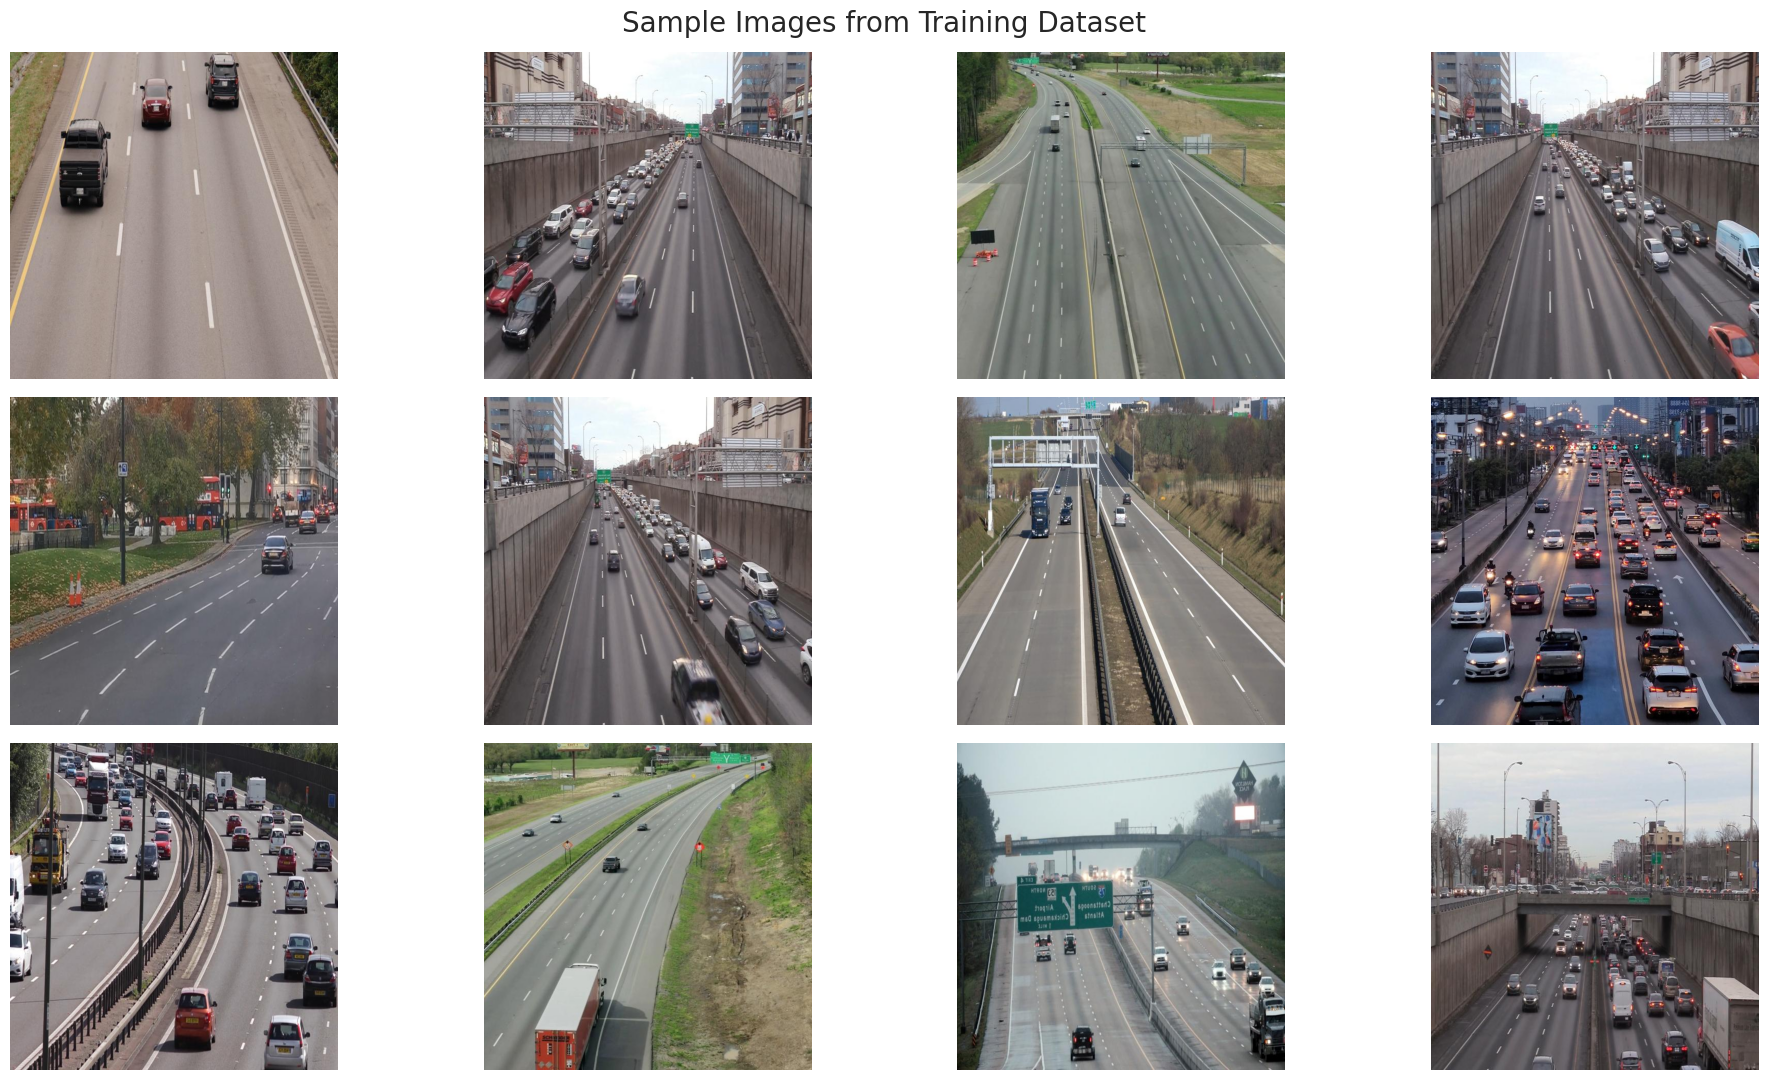

In [9]:
# List all jpg images in the directory
image_files = [file for file in os.listdir(train_images_path) if file.endswith('.jpg')]

# Select 8 images at equal intervals
num_images = len(image_files)
selected_images = [image_files[i] for i in range(0, num_images, num_images // 12)]

# Create a 2x4 subplot
fig, axes = plt.subplots(3, 4, figsize=(20, 11))

# Display each of the selected images
for ax, img_file in zip(axes.ravel(), selected_images):
    img_path = os.path.join(train_images_path, img_file)
    image = Image.open(img_path)
    ax.imshow(image)
    ax.axis('off')

plt.suptitle('Sample Images from Training Dataset', fontsize=20)
plt.tight_layout()
plt.show()

In [10]:
model = YOLO("yolov10n.pt")


100%|██████████| 5.59M/5.59M [00:00<00:00, 118MB/s]


In [11]:
model.fuse()


YOLOv10n summary (fused): 102 layers, 2,299,264 parameters, 0 gradients, 6.7 GFLOPs


In [18]:
results = model.train(
    data=yaml_file_path,  # path to data.yaml
    epochs=100,
    imgsz=640,
    device=0,
    patience=50,
    batch=32,
    optimizer='AdamW',
    lr0=0.001,
    lrf=0.1,
    dropout=0.1,
    seed=0
)


Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.1, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.1, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov10n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=T

100%|██████████| 5.35M/5.35M [00:00<00:00, 106MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.4±0.1 ms, read: 153.8±41.8 MB/s, size: 57.5 KB)


train: Scanning /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/train/labels... 536 images, 0 backgrounds, 0 corrupt: 100%|██████████| 536/536 [00:04<00:00, 109.79it/s]


WARNING ⚠️ train: Cache directory /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.4±0.0 ms, read: 107.0±38.4 MB/s, size: 57.6 KB)


val: Scanning /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/valid/labels... 90 images, 0 backgrounds, 0 corrupt: 100%|██████████| 90/90 [00:00<00:00, 103.29it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/valid is not writeable, cache not saved.


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      6.53G      6.288      7.116      5.595        420        640: 100%|██████████| 17/17 [00:11<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.19s/it]

                   all         90        937    0.00193     0.0555    0.00111   0.000339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      6.87G      4.722      4.251      3.991        359        640: 100%|██████████| 17/17 [00:09<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]

                   all         90        937          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      6.88G      3.726      2.943        3.1        330        640: 100%|██████████| 17/17 [00:14<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all         90        937      0.947     0.0192      0.483      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100       6.9G      3.278      2.523      2.754        368        640: 100%|██████████| 17/17 [00:10<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]

                   all         90        937      0.213       0.79      0.481      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      6.91G      3.063      2.324      2.607        288        640: 100%|██████████| 17/17 [00:08<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]

                   all         90        937      0.705      0.415       0.61      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      6.93G      2.865      2.084      2.467        357        640: 100%|██████████| 17/17 [00:09<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]

                   all         90        937      0.726      0.637       0.74      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.95G      2.737      1.939      2.366        416        640: 100%|██████████| 17/17 [00:08<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]

                   all         90        937      0.682      0.727      0.759      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      6.96G      2.676      1.833      2.328        486        640: 100%|██████████| 17/17 [00:08<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]

                   all         90        937      0.728      0.757       0.83      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      6.98G      2.594      1.736      2.244        475        640: 100%|██████████| 17/17 [00:09<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

                   all         90        937      0.695      0.773      0.806      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      6.99G      2.569      1.724      2.225        270        640: 100%|██████████| 17/17 [00:09<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]

                   all         90        937       0.77      0.813       0.87      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      7.01G      2.479      1.632      2.183        287        640: 100%|██████████| 17/17 [00:08<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]

                   all         90        937      0.786      0.789      0.868       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      7.03G       2.53      1.611      2.195        322        640: 100%|██████████| 17/17 [00:09<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]

                   all         90        937      0.786      0.794      0.875      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      7.04G      2.467      1.547       2.14        391        640: 100%|██████████| 17/17 [00:08<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]

                   all         90        937      0.799      0.821       0.89      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      7.06G      2.457      1.543      2.134        382        640: 100%|██████████| 17/17 [00:08<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]

                   all         90        937      0.823      0.828      0.901      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      7.07G      2.355      1.498      2.126        349        640: 100%|██████████| 17/17 [00:08<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]

                   all         90        937      0.807      0.838      0.899      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      7.09G      2.307      1.441      2.092        213        640: 100%|██████████| 17/17 [00:08<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]

                   all         90        937       0.81      0.849      0.903      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100       7.1G      2.402      1.475      2.115        455        640: 100%|██████████| 17/17 [00:11<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]

                   all         90        937      0.799      0.851      0.893      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      7.12G      2.324      1.443      2.092        315        640: 100%|██████████| 17/17 [00:08<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]

                   all         90        937       0.81      0.827      0.893      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      7.13G      2.355      1.444      2.119        220        640: 100%|██████████| 17/17 [00:08<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]

                   all         90        937      0.803      0.852      0.902      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      7.15G      2.321      1.414       2.09        335        640: 100%|██████████| 17/17 [00:08<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all         90        937      0.823       0.84      0.914      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      7.16G      2.311      1.371      2.071        276        640: 100%|██████████| 17/17 [00:08<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         90        937      0.813      0.825      0.897      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      7.18G      2.284      1.345      2.042        325        640: 100%|██████████| 17/17 [00:08<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

                   all         90        937      0.799      0.885      0.919      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100       7.2G      2.264      1.349      2.067        265        640: 100%|██████████| 17/17 [00:08<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]

                   all         90        937      0.787      0.861      0.899       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      7.21G      2.247      1.318      2.057        284        640: 100%|██████████| 17/17 [00:08<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]

                   all         90        937      0.809      0.873      0.916      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      7.22G       2.26      1.318       2.05        325        640: 100%|██████████| 17/17 [00:09<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]

                   all         90        937      0.796       0.86       0.91      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      7.24G      2.214      1.277      2.054        377        640: 100%|██████████| 17/17 [00:09<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]

                   all         90        937      0.832      0.864      0.926      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      7.26G      2.237      1.338      2.053        232        640: 100%|██████████| 17/17 [00:08<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

                   all         90        937      0.849      0.869      0.927       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      7.28G      2.231      1.258       2.04        416        640: 100%|██████████| 17/17 [00:08<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]

                   all         90        937      0.843      0.876      0.921      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      7.29G      2.201      1.278      2.043        366        640: 100%|██████████| 17/17 [00:08<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]

                   all         90        937      0.845      0.868      0.933      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      7.31G      2.183      1.258      2.035        402        640: 100%|██████████| 17/17 [00:08<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]

                   all         90        937      0.828      0.885      0.922      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      7.32G      2.198      1.262      2.041        213        640: 100%|██████████| 17/17 [00:08<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]

                   all         90        937      0.818      0.892      0.928      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      7.34G      2.162      1.231      2.026        444        640: 100%|██████████| 17/17 [00:08<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]

                   all         90        937      0.837      0.881      0.931      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      7.35G      2.133      1.201      2.014        336        640: 100%|██████████| 17/17 [00:08<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]

                   all         90        937      0.871      0.868      0.942      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      7.37G      2.169      1.201      2.004        310        640: 100%|██████████| 17/17 [00:09<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         90        937       0.83      0.885      0.933      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      7.38G       2.17      1.202          2        322        640: 100%|██████████| 17/17 [00:08<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]

                   all         90        937      0.859      0.868      0.938      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.89G      2.139       1.22      2.009        337        640: 100%|██████████| 17/17 [00:08<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]

                   all         90        937      0.832      0.886      0.934      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      6.43G      2.104      1.163      1.991        245        640: 100%|██████████| 17/17 [00:08<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]

                   all         90        937      0.848      0.871      0.932      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      6.43G      2.093      1.176      1.985        330        640: 100%|██████████| 17/17 [00:09<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all         90        937       0.88      0.858      0.939      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      6.43G      2.141      1.204      1.995        255        640: 100%|██████████| 17/17 [00:08<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]

                   all         90        937      0.842      0.879      0.918      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      6.43G      2.125      1.196      1.978        403        640: 100%|██████████| 17/17 [00:09<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all         90        937      0.845      0.887      0.938      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      6.43G       2.08       1.17      1.982        352        640: 100%|██████████| 17/17 [00:08<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all         90        937      0.877      0.887      0.948      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.43G        2.1      1.154       1.99        354        640: 100%|██████████| 17/17 [00:08<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]

                   all         90        937      0.819      0.907      0.936      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      6.43G      2.066      1.139      1.976        298        640: 100%|██████████| 17/17 [00:08<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]

                   all         90        937      0.875      0.879      0.947      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      6.43G      2.088       1.16      1.967        458        640: 100%|██████████| 17/17 [00:09<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]

                   all         90        937      0.887      0.873      0.947        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      6.43G      2.053      1.125      1.965        352        640: 100%|██████████| 17/17 [00:09<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         90        937      0.896      0.863      0.948      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      6.43G      2.037      1.106       1.97        376        640: 100%|██████████| 17/17 [00:09<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]

                   all         90        937      0.874      0.878      0.946      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      6.43G      2.054       1.14      1.975        326        640: 100%|██████████| 17/17 [00:09<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]

                   all         90        937      0.826      0.903      0.932      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      6.45G      2.086      1.151      1.971        364        640: 100%|██████████| 17/17 [00:08<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]

                   all         90        937      0.819      0.907      0.928      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      6.46G      2.084      1.132      1.974        336        640: 100%|██████████| 17/17 [00:08<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]

                   all         90        937       0.84      0.885      0.926      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      6.48G      2.067      1.117      1.961        310        640: 100%|██████████| 17/17 [00:08<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]

                   all         90        937      0.833        0.9       0.94      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      6.49G      2.072      1.118      1.978        295        640: 100%|██████████| 17/17 [00:09<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

                   all         90        937      0.878      0.879      0.954      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      6.51G      2.008      1.085      1.966        395        640: 100%|██████████| 17/17 [00:08<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]

                   all         90        937      0.852      0.897      0.945      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      6.52G       2.03      1.084      1.961        385        640: 100%|██████████| 17/17 [00:09<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]

                   all         90        937      0.858      0.911      0.957      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      6.54G      2.039      1.092      1.947        332        640: 100%|██████████| 17/17 [00:08<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all         90        937      0.858       0.88      0.944      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      6.55G       2.03      1.077      1.945        417        640: 100%|██████████| 17/17 [00:08<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all         90        937      0.862      0.883      0.946      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      6.57G      2.007      1.099       1.96        233        640: 100%|██████████| 17/17 [00:08<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]

                   all         90        937      0.911      0.843      0.951      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      6.58G      2.006      1.073      1.971        274        640: 100%|██████████| 17/17 [00:08<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]

                   all         90        937      0.822      0.898      0.925      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100       6.6G      2.006        1.1      1.955        406        640: 100%|██████████| 17/17 [00:08<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

                   all         90        937      0.854      0.891      0.942      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      6.62G      2.027      1.091      1.938        380        640: 100%|██████████| 17/17 [00:08<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]

                   all         90        937       0.87      0.901      0.954      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      6.63G      2.017      1.077      1.961        368        640: 100%|██████████| 17/17 [00:08<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

                   all         90        937      0.877      0.896      0.955      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      6.65G      2.008      1.068      1.948        349        640: 100%|██████████| 17/17 [00:08<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]

                   all         90        937      0.875      0.878      0.949      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      6.66G      1.993      1.055      1.928        295        640: 100%|██████████| 17/17 [00:08<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]

                   all         90        937      0.864      0.906       0.95       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      6.68G      1.985      1.036      1.942        282        640: 100%|██████████| 17/17 [00:08<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all         90        937      0.867      0.907      0.952      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100       6.7G      2.009      1.055      1.944        262        640: 100%|██████████| 17/17 [00:09<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all         90        937      0.895      0.885      0.955      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      6.71G      1.994      1.034      1.932        450        640: 100%|██████████| 17/17 [00:08<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

                   all         90        937      0.855      0.898      0.945      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      6.73G      1.981      1.046      1.944        297        640: 100%|██████████| 17/17 [00:08<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

                   all         90        937      0.885      0.899       0.95      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      6.74G      1.969      1.035      1.936        310        640: 100%|██████████| 17/17 [00:08<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]

                   all         90        937      0.857        0.9       0.95      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      6.76G      1.949      1.019      1.925        279        640: 100%|██████████| 17/17 [00:08<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]

                   all         90        937      0.872      0.901      0.957      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      6.77G      1.985      1.027      1.931        380        640: 100%|██████████| 17/17 [00:08<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]

                   all         90        937      0.871      0.904      0.954      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      6.79G      1.974      1.054      1.939        312        640: 100%|██████████| 17/17 [00:09<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]

                   all         90        937      0.883      0.889      0.959      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      7.14G      1.964      1.023      1.927        324        640: 100%|██████████| 17/17 [00:09<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all         90        937      0.867        0.9      0.954      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      7.16G       1.92      1.005       1.92        392        640: 100%|██████████| 17/17 [00:08<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all         90        937      0.869      0.907      0.949      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      7.17G      1.926       1.02      1.928        397        640: 100%|██████████| 17/17 [00:08<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all         90        937      0.863      0.908      0.953      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      7.19G      1.934      1.005      1.935        384        640: 100%|██████████| 17/17 [00:08<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]

                   all         90        937      0.865      0.899      0.944      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      7.21G      1.932      1.018      1.921        363        640: 100%|██████████| 17/17 [00:08<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]

                   all         90        937      0.858      0.904      0.949      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      7.22G      1.892     0.9867       1.92        370        640: 100%|██████████| 17/17 [00:08<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

                   all         90        937      0.881      0.872      0.955      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      7.24G      1.951     0.9912      1.915        374        640: 100%|██████████| 17/17 [00:08<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]

                   all         90        937      0.847      0.902      0.944      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      7.25G      1.907     0.9946      1.922        339        640: 100%|██████████| 17/17 [00:08<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]

                   all         90        937      0.875      0.887      0.942      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      7.27G      1.899     0.9766      1.916        399        640: 100%|██████████| 17/17 [00:08<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.05it/s]

                   all         90        937      0.849      0.912      0.944       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      7.29G      1.881     0.9786      1.907        305        640: 100%|██████████| 17/17 [00:08<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]

                   all         90        937      0.858      0.921      0.954      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100       7.3G      1.882     0.9746      1.895        406        640: 100%|██████████| 17/17 [00:08<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]

                   all         90        937      0.846      0.931       0.95      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      7.32G      1.932     0.9985      1.917        323        640: 100%|██████████| 17/17 [00:08<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         90        937      0.886      0.892      0.947      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      7.33G      1.899     0.9991      1.919        361        640: 100%|██████████| 17/17 [00:09<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]

                   all         90        937      0.888      0.887      0.949      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      7.35G      1.905     0.9967      1.906        352        640: 100%|██████████| 17/17 [00:08<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.72it/s]

                   all         90        937      0.868      0.885      0.948      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      7.36G      1.878      0.991       1.92        253        640: 100%|██████████| 17/17 [00:08<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]

                   all         90        937      0.895      0.889      0.952      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      6.11G       1.87     0.9734        1.9        346        640: 100%|██████████| 17/17 [00:08<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

                   all         90        937      0.868      0.918      0.946      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      6.44G      1.885     0.9607      1.905        507        640: 100%|██████████| 17/17 [00:08<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all         90        937      0.868      0.901      0.953      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      6.44G      1.834     0.9504      1.902        333        640: 100%|██████████| 17/17 [00:08<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]

                   all         90        937      0.896      0.887      0.952      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      6.44G      1.877     0.9777      1.896        442        640: 100%|██████████| 17/17 [00:08<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]

                   all         90        937      0.859      0.904      0.946      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      6.44G      1.884     0.9642      1.896        419        640: 100%|██████████| 17/17 [00:09<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         90        937      0.867      0.905      0.951      0.707


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      6.44G      1.805     0.9292      1.907        259        640: 100%|██████████| 17/17 [00:12<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]

                   all         90        937      0.875      0.884      0.951       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      6.44G      1.794     0.8851      1.901        246        640: 100%|██████████| 17/17 [00:08<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]

                   all         90        937       0.86      0.915       0.95      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      6.44G      1.774     0.8892      1.904        205        640: 100%|██████████| 17/17 [00:08<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all         90        937       0.91      0.866      0.952      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      6.44G      1.771     0.8832      1.891        239        640: 100%|██████████| 17/17 [00:08<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

                   all         90        937      0.896      0.862       0.95      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      6.44G       1.75      0.881      1.881        224        640: 100%|██████████| 17/17 [00:07<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]

                   all         90        937      0.867      0.898      0.949      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      6.44G      1.755     0.8722      1.882        219        640: 100%|██████████| 17/17 [00:08<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]

                   all         90        937      0.886      0.893      0.953      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      6.44G      1.742     0.8645      1.888        188        640: 100%|██████████| 17/17 [00:08<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all         90        937      0.871      0.911      0.949      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      6.44G      1.727     0.8458      1.872        181        640: 100%|██████████| 17/17 [00:08<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all         90        937      0.851      0.921       0.95      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      6.44G      1.716     0.8417      1.866        290        640: 100%|██████████| 17/17 [00:08<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         90        937      0.892      0.889      0.953      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      6.44G      1.719     0.8424      1.873        304        640: 100%|██████████| 17/17 [00:07<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

                   all         90        937      0.898      0.897      0.955      0.713



100 epochs completed in 0.306 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 5.8MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 5.8MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 102 layers, 2,265,363 parameters, 0 gradients, 6.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


                   all         90        937      0.882      0.889      0.959      0.716
Speed: 0.3ms preprocess, 3.1ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/train2


In [19]:
import os

base_path = '/content/runs/detect'
print("All training runs:")
print(os.listdir(base_path))


All training runs:
['train', 'train2']


In [20]:
# List contents of the 'train' folder inside 'detect'
train_dir = '/content/runs/detect/train2'
print(f"Contents of {train_dir}:")
print(os.listdir(train_dir))


Contents of /content/runs/detect/train2:
['val_batch0_pred.jpg', 'train_batch1532.jpg', 'val_batch0_labels.jpg', 'R_curve.png', 'F1_curve.png', 'args.yaml', 'train_batch1.jpg', 'val_batch1_labels.jpg', 'results.csv', 'labels_correlogram.jpg', 'confusion_matrix.png', 'train_batch1530.jpg', 'train_batch0.jpg', 'train_batch2.jpg', 'confusion_matrix_normalized.png', 'val_batch1_pred.jpg', 'train_batch1531.jpg', 'labels.jpg', 'results.png', 'P_curve.png', 'weights', 'PR_curve.png']


In [21]:
import pandas as pd

# Path to the results.csv file
results_csv_path = '/content/runs/detect/train2/results.csv'

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(results_csv_path)

# Remove leading whitespace from column names
df.columns = df.columns.str.strip()

# Display the first few rows of the dataframe
df.head()


epoch     time  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1  14.3297         6.28794         7.11636         5.59505   
1      2  24.9733         4.72213         4.25057         3.99147   
2      3  41.6094         3.72598         2.94255         3.10038   
3      4  54.3813         3.27832         2.52258         2.75378   
4      5  65.4350         3.06266         2.32371         2.60746   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.00193            0.05550           0.00111   
1               0.00000            0.00000           0.00000   
2               0.94737            0.01921           0.48304   
3               0.21307            0.78975           0.48118   
4               0.70492            0.41515           0.60955   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
0              0.00034       6.88167       7.02876       6.13403  0.084160   
1              0.00000       6.53696       8.56706       5.26958  0.067327   
2              0.25688       4.90331       8.96764       3.94190  0.050491   
3              0.29747       3.12112       6.24412       2.87952  0.033652   
4              0.36811       2.89161       4.00625       2.64479  0.016810   

     lr/pg1    lr/pg2  
0  0.000160  0.000160  
1  0.000327  0.000327  
2  0.000491  0.000491  
3  0.000652  0.000652  
4  0.000810  0.000810

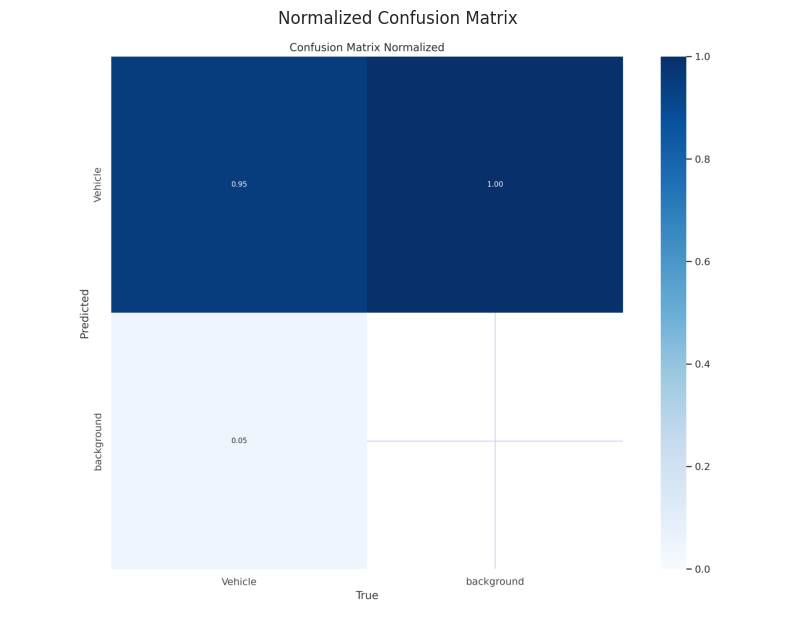

In [22]:
# Use the correct path for plotting and confusion matrix
base_path = '/content/runs/detect/train2'

# For plotting learning curves
results_csv_path = os.path.join(base_path, 'results.csv')
df = pd.read_csv(results_csv_path)
df.columns = df.columns.str.strip()

# For confusion matrix
import cv2
import matplotlib.pyplot as plt

conf_matrix_path = os.path.join(base_path, 'confusion_matrix_normalized.png')
cm_img = cv2.imread(conf_matrix_path)
cm_img = cv2.cvtColor(cm_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(cm_img)
plt.axis('off')
plt.title("Normalized Confusion Matrix")
plt.show()


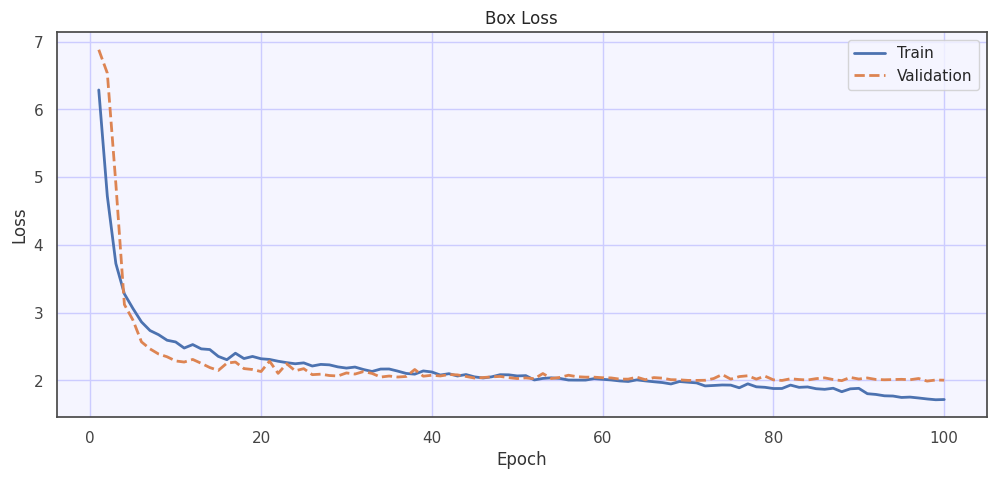

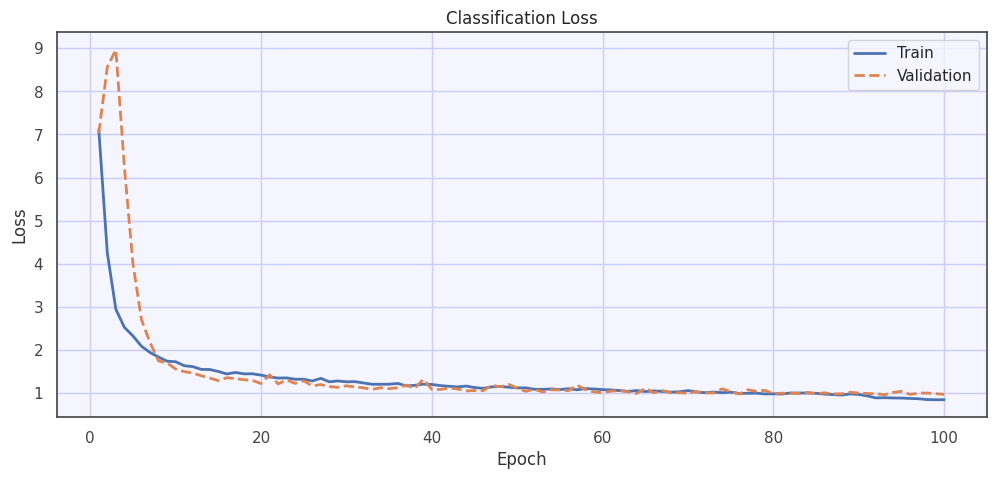

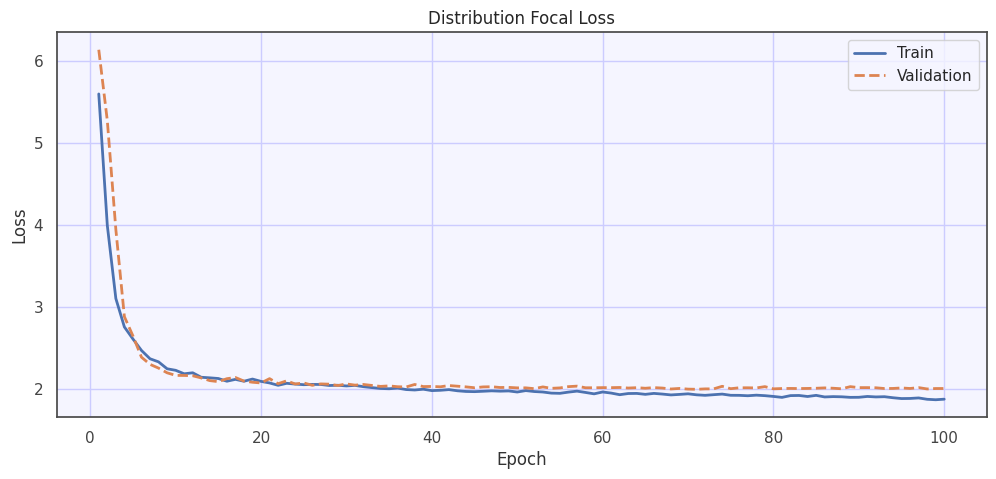

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Path to the results.csv file
results_csv_path = '/content/runs/detect/train2/results.csv'

# Load and clean
df = pd.read_csv(results_csv_path)
df.columns = df.columns.str.strip()

# Plot function
def plot_learning_curve(df, train_loss_col, val_loss_col, title):
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=df, x='epoch', y=train_loss_col, label='Train', linewidth=2)
    sns.lineplot(data=df, x='epoch', y=val_loss_col, label='Validation', linewidth=2, linestyle='--')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot losses
plot_learning_curve(df, 'train/box_loss', 'val/box_loss', 'Box Loss')
plot_learning_curve(df, 'train/cls_loss', 'val/cls_loss', 'Classification Loss')
plot_learning_curve(df, 'train/dfl_loss', 'val/dfl_loss', 'Distribution Focal Loss')


In [24]:
# Construct the path to the best model weights file using os.path.join
best_model_path = os.path.join(base_path, 'weights/best.pt')

# Load the best model weights into the YOLO model
best_model = YOLO(best_model_path)

# Validate the best model using the validation set with default parameters
metrics = best_model.val(split='val')

Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 102 layers, 2,265,363 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 176.2±66.2 MB/s, size: 61.7 KB)


val: Scanning /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/valid/labels... 90 images, 0 backgrounds, 0 corrupt: 100%|██████████| 90/90 [00:00<00:00, 535.89it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/valid is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.87it/s]


                   all         90        937      0.883      0.889      0.959      0.716
Speed: 4.4ms preprocess, 5.6ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/val


In [25]:
# Convert the dictionary to a pandas DataFrame and use the keys as the index
metrics_df = pd.DataFrame.from_dict(metrics.results_dict, orient='index', columns=['Metric Value'])

# Display the DataFrame
metrics_df.round(3)

Metric Value
metrics/precision(B)         0.883
metrics/recall(B)            0.889
metrics/mAP50(B)             0.959
metrics/mAP50-95(B)          0.716
fitness                      0.740

In [27]:
from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Copy the results.csv to your Drive
shutil.copy('runs/detect/train2/results.csv', '/content/drive/MyDrive/results.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/results.csv'

#TESTING ON AN IMAGE

In [46]:
from google.colab import files
uploaded = files.upload()


Saving test5.jpg to test5.jpg
Saving test4.jpg to test4 (1).jpg
Saving test3.jpg to test3 (1).jpg
Saving test2.jpg to test2 (2).jpg
Saving top-view-test.jpg to top-view-test (2).jpg


In [60]:
def check_traffic_density(image_path, model):
    """
    Runs inference on a given image and prints traffic density info.

    Args:
        image_path (str): Path to the input image.
        model (YOLO): A trained YOLO model instance.
    """
    from PIL import Image
    import matplotlib.pyplot as plt
    import os

    # Inference
    results = model(image_path)

    # Count vehicles
    num_vehicles = len(results[0].boxes)

    # Determine traffic density
    if num_vehicles >= 20:
        density = "High"
    elif num_vehicles >= 10:
        density = "Medium"
    else:
        density = "Low"

    # Show result with bounding boxes
    results[0].show()

    # Print summary
    print(f"\nImage: {os.path.basename(image_path)}")
    print(f"Detected {num_vehicles} vehicles → Traffic Density: {density}")

    # Access prediction data (boxes, labels, scores)
    predicted_boxes = results[0].boxes.xywh  # predicted bounding boxes in xywh format
    predicted_scores = results[0].boxes.conf  # confidence scores
    predicted_labels = results[0].boxes.cls  # predicted class labels (vehicle, etc.)

    # Print the details about the predictions
    print(f"Predicted boxes: {predicted_boxes}")
    print(f"Confidence scores: {predicted_scores}")
    print(f"Predicted labels: {predicted_labels}")
    print(f"Number of detected vehicles: {num_vehicles}")



image 1/1 /content/test5.jpg: 448x640 15 Vehicles, 13.0ms
Speed: 2.7ms preprocess, 13.0ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


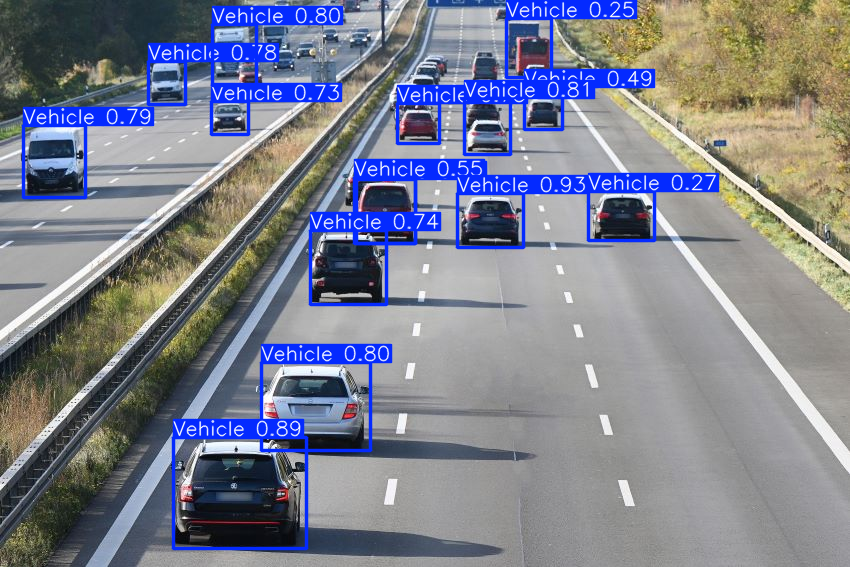


Image: test5.jpg
Detected 15 vehicles → Traffic Density: Medium
Predicted boxes: tensor([[490.3115, 220.4350,  65.4283,  53.6896],
        [239.9004, 492.6649, 133.0070, 110.7083],
        [487.5470, 126.3738,  46.0868,  55.3739],
        [315.7180, 406.3810, 108.8878,  88.1780],
        [234.6378,  55.0559,  44.2493,  61.6793],
        [ 54.7147, 161.6179,  61.8942,  72.4046],
        [167.4473,  82.6886,  37.0420,  42.8946],
        [418.1795, 123.4553,  41.7209,  39.9691],
        [348.7000, 267.1578,  75.9902,  73.8832],
        [230.0610, 118.1339,  37.7867,  33.5901],
        [385.0883, 210.9221,  60.4972,  65.8709],
        [543.9701, 108.5775,  38.0361,  42.3074],
        [385.9642, 211.8763,  59.6236,  63.9985],
        [621.8469, 215.9993,  65.9238,  49.7344],
        [529.2440,  47.6703,  45.1839,  58.9001]], device='cuda:0')
Confidence scores: tensor([0.9298, 0.8866, 0.8076, 0.7996, 0.7971, 0.7931, 0.7762, 0.7451, 0.7399, 0.7284, 0.5528, 0.4942, 0.3317, 0.2744, 0.2501], de

In [61]:
# Load the model if not already done
model = YOLO(best_model_path)

# Get the uploaded image name
image_path = list(uploaded.keys())[0]

# Call the function
check_traffic_density(image_path, model)


#QUANTIZING
